<H1>I. Pré-traitement des données du TRHAA</H1>

<H2>I.1. Import des données du TRHAA</H2>

In [2]:
# import des modules nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from distinctipy import distinctipy
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.formula.api as statsapi
import statsmodels as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import xlrd as xlrd
from matplotlib import font_manager # for mac users

# Modifier les paramètres d'affichage de la sortie des commandes dans Jupyter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# import de la police Garamond
#if system==windows:
#    garamond_font = FontProperties(fname="Macintosh HD/Bibliotheque/Fonts/Microsoft/GARA.TTF",size=14)
#    timesnewroman_font = FontProperties(fname="C:/Windows/Fonts/TIMES.TTF",size=14)
#if system==mac:
#font_manager.findSystemFonts(fontpaths="None", fontext="ttf")
#font_manager.findfont("Garamond") 

import des fichiers de données et des fichiers d'url pour récupérer les champs "Modifié le" et Notices associée".
Etant donné que les résultats de recherche ne peuvent pas contenir plus de 10000 enregistrements nous avons morcellé la recherche en 4 requêtes :
Il y a 4414 résultats qui correspondent à /France/Paris et Ile de France /Panthéon Sorbonne P1
Il y a 6335 résultats qui correspondent à /France/Paris et Ile de France /Tout saut Paris Panthéon Sorbonne P1
Il y a 7411 résultats qui correspondent à /France/Tout sauf Paris et Ile de France
Il y a 60 résultats qui correspondent à /Italie, Suisse et Non Renseignés
Soit un total de 18220 au lieu de 18217 résultats dans TRHAA.


In [3]:


df_data_temp_4414 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_Sorbonne_4414.xlsx", sheet_name=0)
df_data_temp_6335 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_TtSaufsorbonne_6335.xlsx", sheet_name=0)
df_data_temp_7411 = pd.read_excel("input/TRHAA/DATA for Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_data_temp_60 = pd.read_excel("input/TRHAA/DATA for TtSaufFrNonRenseignes_60.xlsx",sheet_name=0)

df_url_temp_6335 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_TtSaufSorbonne_6335.xlsx",sheet_name=0)
df_url_temp_4414 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_Sorbonne_4414.xlsx",sheet_name=0)
df_url_temp_7411 = pd.read_excel("input/TRHAA/URL_List_Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_url_temp_60 = pd.read_excel("input/TRHAA/URL_List_TtSaufFrance_NonRenseigne_60.xlsx",sheet_name=0)


Croisement des dataframe DATA et URL sur la clé "URL de la page" pour avoir l'ensemble des données pour chaque

In [4]:
# Merge des fichiers

# Column bind des logs et questionnaires
df_4414_temp = pd.merge(df_data_temp_4414, df_url_temp_4414,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_6335_temp = pd.merge(df_data_temp_6335, df_url_temp_6335,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_7411_temp = pd.merge(df_data_temp_7411, df_url_temp_7411,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_60_temp = pd.merge(df_data_temp_60, df_url_temp_60,on=['Original_URL'],how='outer',suffixes=('','_url'))
print("Shape de df_4414_temp: ", df_4414_temp.shape)
print("shape de df_6335_temp: ", df_6335_temp.shape)
print("Shape de df_7411_temp: ", df_7411_temp.shape)
print("Shape de df_60_temp: ", df_60_temp.shape)


Shape de df_4414_temp:  (4414, 23)
shape de df_6335_temp:  (6335, 23)
Shape de df_7411_temp:  (7411, 23)
Shape de df_60_temp:  (60, 23)


Le nombre de colonnes est identique entre tous les fichiers (23), le nombre de lignes correspond aux nombres prévus donc on peut concaténer l'ensemble des dataframes pour obtenir un seul dataframe.

In [5]:
# Concaténation des dataframes

df_tmp_1et2 = pd.concat([df_4414_temp,df_6335_temp], ignore_index=True)
df_tmp_3et4=pd.concat([df_7411_temp,df_60_temp], ignore_index=True)
df_trhaa_initial = pd.concat([df_tmp_1et2,df_tmp_3et4], ignore_index=True)

# Vérification du format
print("Shape de df_tmp: ", df_trhaa_initial.shape)

# Affichage des colonnes et renommage des colonnes ayant des noms génériques

print("Colonnes: ", df_trhaa_initial.columns)
df_trhaa_initial.rename(columns={"Field3": "ModifieLe","Field4": "NoticeAssocieeA"},inplace=True)
print("Colonnes: ", df_trhaa_initial.columns)


Shape de df_tmp:  (18220, 23)
Colonnes:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'Field3', 'Field4'],
      dtype='object')
Colonnes:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA'],
      dtype='obje

<H2>I.2. Qualité des données initiales</H2>

Les colonnes qui ne contiennent pas de valeurs

In [6]:
# Info
df_trhaa_initial.info()

df_trhaa_initial.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Illustration                       18202 non-null  object
 1   TypeDocument                       18202 non-null  object
 2   TitreOuvrage                       18199 non-null  object
 3   Ref_Complete                       17566 non-null  object
 4   LangueDocument                     17981 non-null  object
 5   RoleAuteurPrincipal                18194 non-null  object
 6   TypeMemoire                        17966 non-null  object
 7   AnneeSoutenance                    16051 non-null  object
 8   SoutenanceDateDebut                15678 non-null  object
 9   SoutenanceDateFin                  15913 non-null  object
 10  AuteurPrincipal                    18201 non-null  object
 11  TAuteurs                           18202 non-null  object
 12  Doma

Illustration                            18
TypeDocument                            18
TitreOuvrage                            21
Ref_Complete                           654
LangueDocument                         239
RoleAuteurPrincipal                     26
TypeMemoire                            254
AnneeSoutenance                       2169
SoutenanceDateDebut                   2542
SoutenanceDateFin                     2307
AuteurPrincipal                         19
TAuteurs                                18
DomainesDeRecherche                    383
UniversitesDeSoutenancePrincipale      267
UniversitesDeSoutenance                267
Original_URL                             0
GestionNotice                           18
Indexation                           11167
Commentaires                         17787
Titre                                   20
Field1_links                             0
ModifieLe                                0
NoticeAssocieeA                          0
dtype: int6

Affichage du remplissage des champs

<Axes: >

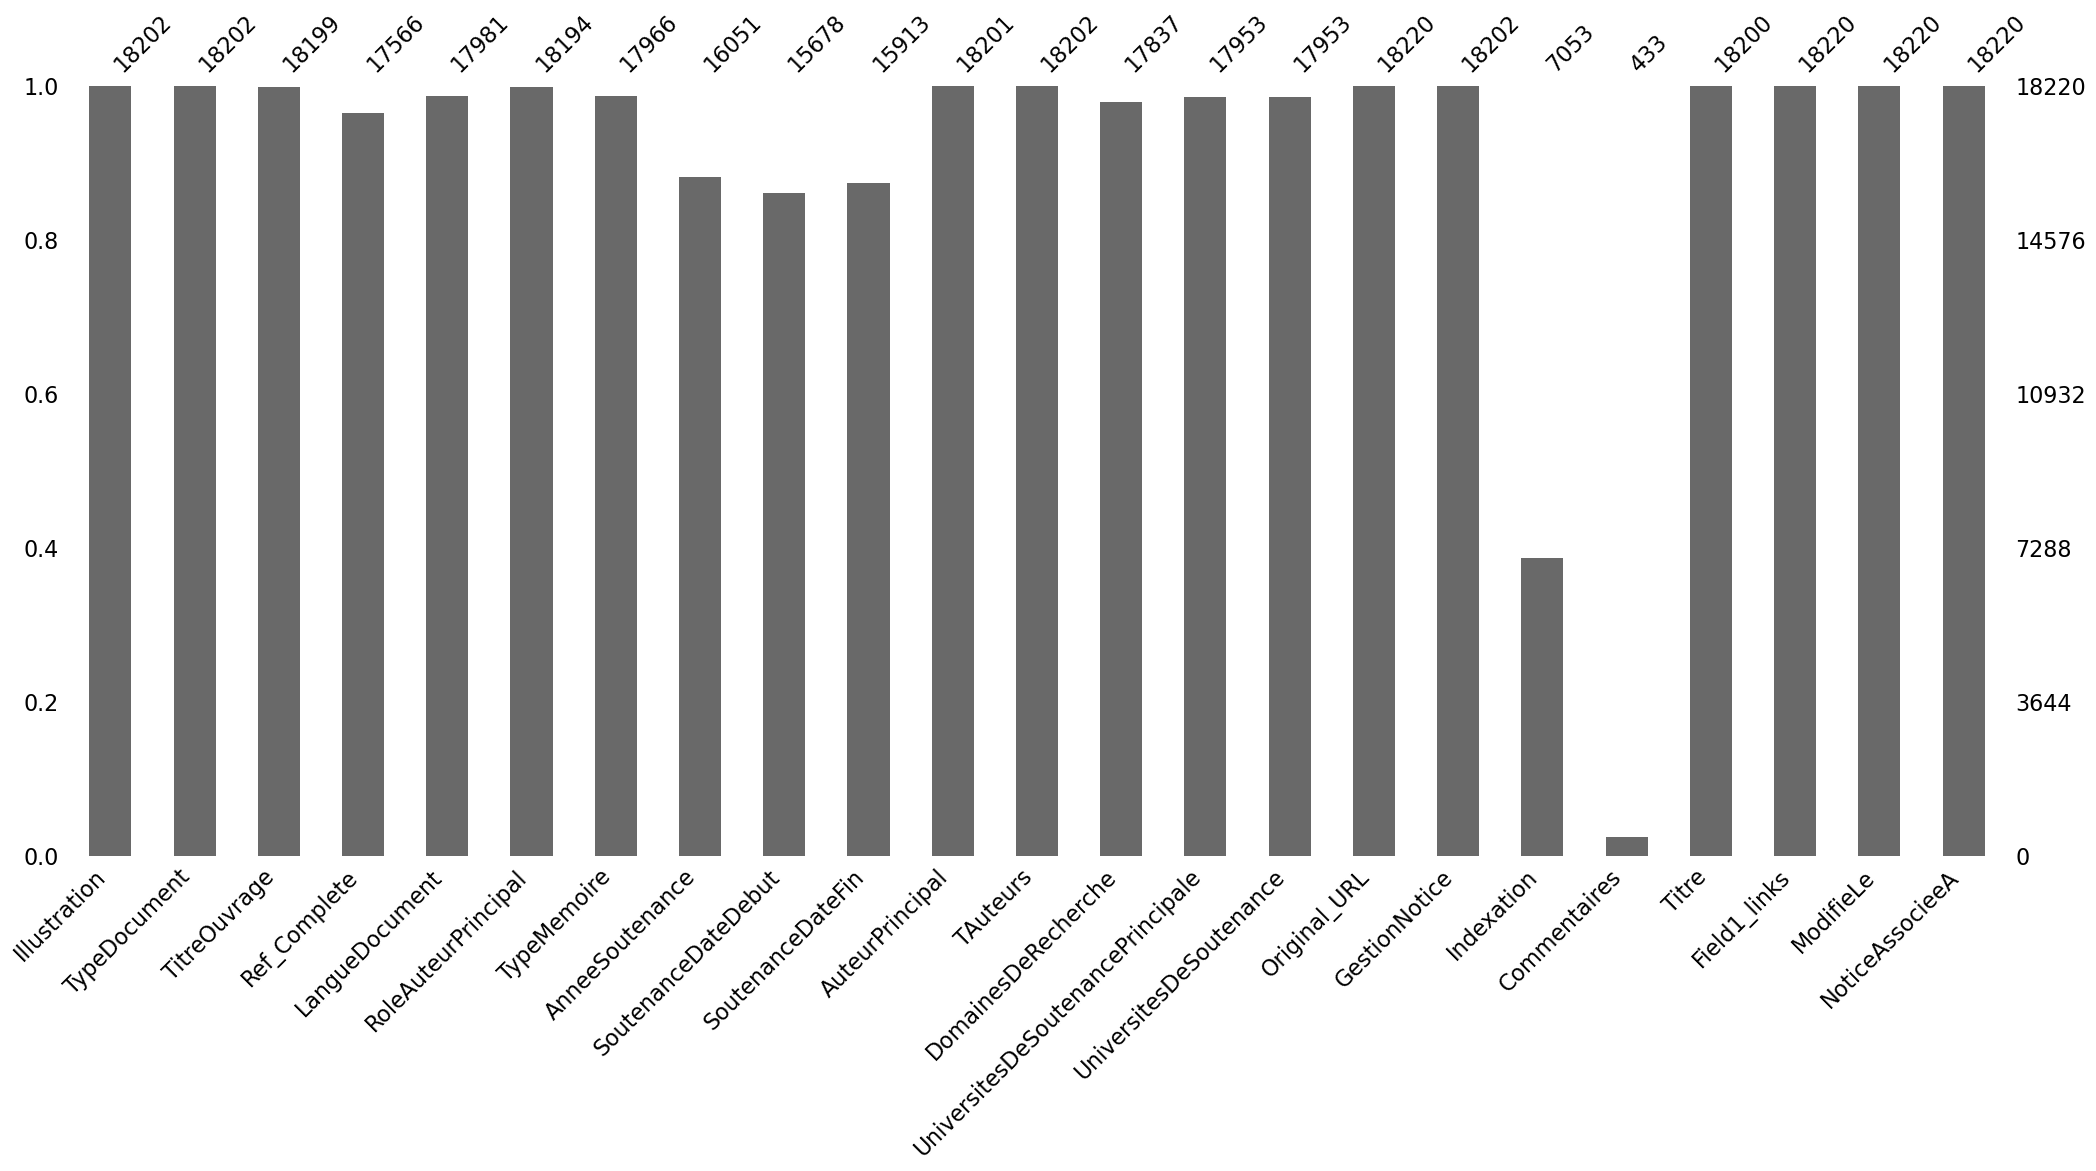

In [7]:
# Analyse colonnes
msno.bar(df_trhaa_initial)


Visualisation des différentes valeurs de certains champs : TypeDocument, LangueDocument, RoleAuteurPrincipal, TypeMemoire

In [8]:
# Visualisation des différentes valeurs de certains champs : TypeDocument, LangueDocument, RoleAuteurPrincipal, TypeMemoire

print(df_trhaa_initial.groupby(["TypeDocument"])["TypeDocument"].count())

# on trouve quasiment exclusivement des mémoires (77,80%) /18202) et des thèses (22,05%)

TypeDocument
DPLG                                     5
contribution à un ouvrage                1
mémoire                              14169
ouvrage                                 11
thèse                                 4015
travail personnel de fin d'études        1
Name: TypeDocument, dtype: int64


In [9]:
print(df_trhaa_initial.groupby(["TypeMemoire"])["TypeMemoire"].count())

TypeMemoire
Habilitation à diriger des recherches                    61
Mémoire de 2e cycle de l'Ecole du Louvre                316
Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)         91
Mémoire de DEA                                         1847
Mémoire de DESS                                           1
Mémoire de DRA                                           71
Mémoire de l'IFROA                                       62
Mémoire de master professionnel 1re année                32
Mémoire de master professionnel 2e année                139
Mémoire de master recherche 1re année                  4164
Mémoire de master recherche 2e année                   3214
Mémoire de maîtrise                                    4177
Mémoire de maîtrise de sciences et techniques (MST)      15
Thèse d'État                                              2
Thèse de 3e cycle                                         2
Thèse de doctorat                                        29
Thèse de l'Ecole des chartes

In [10]:
print(df_trhaa_initial.groupby(["LangueDocument"])["LangueDocument"].count())

# Essentiellement des travaux en langue française

LangueDocument
Allemand         2
Anglais          4
Espagnol         1
Français     17973
Portugais        1
Name: LangueDocument, dtype: int64


In [11]:
print(df_trhaa_initial.groupby(["RoleAuteurPrincipal"])["RoleAuteurPrincipal"].count())

# Les auteurs principaux sont mentionnés (18182 sur 18202) quasiment tout le temps sauf une dizaine de fois où, très probablement, une erreur de saisie a mentionné le directeut de mémoire à la place

print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de mémoire"][["Ref_Complete","AuteurPrincipal"]])
print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de thèse"][["Ref_Complete","AuteurPrincipal"]])

RoleAuteurPrincipal
auteur                  18182
directeur de mémoire       11
directeur de thèse          1
Name: RoleAuteurPrincipal, dtype: int64
                                            Ref_Complete       AuteurPrincipal
1321   Gallier, Valentine. La Fuite de Gradlon : entr...     Méneux, Catherine
1577   Posca, Francesca Romana. Les femmes dans les m...       Dagen, Philippe
1606   Gremel, Clémence. L’Estampe et l’affiche (1897...     Méneux, Catherine
1607   Ghnadour, Yasmine. En quête d’identité. La col...     Méneux, Catherine
3783   Langlois, Amandine. Patrimoine, politiques cul...     Méneux, Catherine
3784   Brault, Julie. Le périodique illustré Cocorico...        Gispert, Marie
3785   Garcia, Constance. Désaccord d’interprétation ...        Gispert, Marie
3792   Garden, Morgane. Les « cadres-souvenirs » des ...     Pernoud, Emmanuel
3793   Vasseur, Delphine. Les représentations de la f...     Méneux, Catherine
9131   Palmieri, Fiorella. Les Modistes parisiennes d...    

Listons les enregistements marqués comme thèse (TypeDocument) mais qui ne le sont pas à priori (TypeMemoire)

Vérification si les thèses inscrites ou soutenues (TypeMémoire) sont bien des Thèses (TypeDocument)

Si TypeMemoire est thèses inscrites ou soutenues, et TypeDocument est thèse alors verifThese = 1. On a 4015 thèses dans TypeDocument, et 1948 thèses inscrites, 1784 thèses soutenues dans TypeMémoire, en supposant qu'une thèse soutenue, et donc préalablement inscrite, n'est comptabilisée que comme thèse soutenue. Résultat plutôt bon avec 92% de correspondance (3729 / 4015). On peut donc 1) Ajouter des champs TheseInscrite et TheseSoutenue sur le statut des thèses 2) Poursuivre avec la simplification des TypeMemoire, en particulier les thèses inscrites ou soutenues qui sont très probablement des thèses de doctorat

In [12]:
# valeurs par défaut
df_trhaa_tmp = pd.DataFrame([])
df_trhaa_tmp["verifThese"] = df_trhaa_initial["TypeMemoire"]
df_trhaa_tmp["verifThese"] = ""

# debug
print(len(df_trhaa_initial["TypeMemoire"]))

# parcours
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    if ((itemTypeMemoire == "Thèse inscrite") or (itemTypeMemoire == "Thèse soutenue")) and (itemTypeDocument == "thèse"):
        df_trhaa_tmp["verifThese"].iloc[i] = "thèse confirmée"
print("Thèses confirmées: ", df_trhaa_tmp.groupby(["verifThese"])["verifThese"].count())


18220


Thèses confirmées:  verifThese
                   14491
thèse confirmée     3729
Name: verifThese, dtype: int64


In [13]:
# init
df_trhaa_tmp["verifNONThese"] = df_trhaa_tmp["verifThese"]
df_trhaa_tmp["verifNONThese"] = ""

# parcours
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    #print("TypeMemoire: ", itemTypeMemoire, "TypeDocument: ", itemTypeDocument)
    if ((itemTypeMemoire != "Thèse inscrite") and 
        (itemTypeMemoire != "Thèse soutenue") and 
        (itemTypeMemoire != "Thèse de doctorat") and 
        (itemTypeMemoire != "Habilitation à diriger des recherches") and 
    (itemTypeDocument == "thèse")):
        df_trhaa_tmp["verifNONThese"].iloc[i] = "thèse NON confirmée"
print("Thèses NON confirmées: ", df_trhaa_tmp.groupby(["verifNONThese"])["verifNONThese"].count())




Thèses NON confirmées:  verifNONThese
                       18024
thèse NON confirmée      196
Name: verifNONThese, dtype: int64


Distinction des différents domaines de recherche

Il y a 58 domaines de recherches différents pour l'ensemble des 18000 fiches. Ce chiffre semble montrer que les entrées de la base de données sont contrôlées pour cette donnée. Une catégorisation avec moins de valeurs différentes utilisant de plus larges domaines de recherches sera nécessaire pour rendre cette données exploitable. A placer en annexe dans le rapport.

In [14]:
# lib
import re

#
df_trhaa_DomaineRecherche = pd.DataFrame([])
for i in range(len(df_trhaa_initial["DomainesDeRecherche"])):
    try:
        strDomainesComplets = df_trhaa_initial["DomainesDeRecherche"][i].split(":")
        strDomaines = strDomainesComplets[1:][0]
        lstDomaines = strDomaines[2:].split("\n")
        for j in range(len(lstDomaines)):
            strpDomaines = lstDomaines[j].strip()
            if len(strpDomaines) != 0:
                nouvelle_ligne = pd.DataFrame({'ListeDomaines': [strpDomaines]})
                df_trhaa_DomaineRecherche = pd.concat([df_trhaa_DomaineRecherche,nouvelle_ligne], ignore_index=True)
    except:
        print("exception")
    
df_trhaa_DomaineRecherche.reset_index()

print("Nb de domaines de recherche distincts: ",len(df_trhaa_DomaineRecherche.groupby("ListeDomaines")))
print("Domaines de recherche distincts: ",df_trhaa_DomaineRecherche.groupby(["ListeDomaines"])["ListeDomaines"].count())

exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception


Analyse du champ UniversitésDeSoutenancePrincipale

In [15]:
# init
df_trhaa_UniversitesDeSoutenancePrincipale = pd.DataFrame([])

df_trhaa_UniversitesDeSoutenancePrincipale  =  df_trhaa_initial.groupby("UniversitesDeSoutenancePrincipale").count()
print("Quelques unes des universités \n\n", df_trhaa_UniversitesDeSoutenancePrincipale["Illustration"].sort_values(ascending=False).reset_index().head(100))
print("\nNb d'Universités distinctes: ", len(df_trhaa_UniversitesDeSoutenancePrincipale.groupby("UniversitesDeSoutenancePrincipale")))

Quelques unes des universités 

                     UniversitesDeSoutenancePrincipale  Illustration
0              Université Panthéon-Sorbonne - Paris I          4399
1                Université Paris-Sorbonne - Paris IV          3360
2                                     Ecole du Louvre          1184
3                        Université Lumière - Lyon II           915
4                           Université Paris-Nanterre           886
5            Université Charles-de-Gaulle - Lille III           611
6                                 Université de Tours           609
7                          Université d'Aix-Marseille           601
8                            Université de Strasbourg           535
9                              Université de Poitiers           507
10                            Université de Bourgogne           419
11               Université Paul-Valéry - Montpellier           412
12                               Université Rennes II           411
13             

<H1>II. Enrichissement des données</H1>

<H2>II.1. Nouveaux champs</H2>

<p>Les dates de dernière modification

In [16]:
# copie du df_trhaa_initial vers df_trhaa pour conserver la version initiale telle quelle
df_trhaa = df_trhaa_initial

In [17]:
# Remplissage des champs SoutenanceDateDebut et Fin à partir de la colonne AnneeSoutenance

import re

pattern = r"(\d{4})(?:\s*-\s*(\d{4}))?"

for i in range(len(df_trhaa["AnneeSoutenance"])):
    ligne = df_trhaa["AnneeSoutenance"][i]
    if type(ligne) == str:
        matches = re.findall(pattern, ligne)
        for match in matches:
            # Si la deuxième date est absente, le groupe de capture 2 sera vide (None).
            # Vous pouvez le remplacer par une valeur par défaut si nécessaire.
            df_trhaa["SoutenanceDateDebut"][i] = match[0]
            df_trhaa["SoutenanceDateFin"][i] = match[1] if match[1] else match[0]  # Utilisez une valeur par défaut ici si nécessaire

# Convertit au format entier pour les années df.ID = pd.to_numeric(df.ID, errors='coerce').fillna(0).astype(np.int64)
df_trhaa.SoutenanceDateDebut = pd.to_numeric(df_trhaa.SoutenanceDateDebut,errors="coerce").fillna(0).astype(np.int64)
df_trhaa.SoutenanceDateFin = pd.to_numeric(df_trhaa.SoutenanceDateFin,errors="coerce").fillna(0).astype(np.int64)

print(df_trhaa.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Illustration                       18202 non-null  object
 1   TypeDocument                       18202 non-null  object
 2   TitreOuvrage                       18199 non-null  object
 3   Ref_Complete                       17566 non-null  object
 4   LangueDocument                     17981 non-null  object
 5   RoleAuteurPrincipal                18194 non-null  object
 6   TypeMemoire                        17966 non-null  object
 7   AnneeSoutenance                    16051 non-null  object
 8   SoutenanceDateDebut                18220 non-null  int64 
 9   SoutenanceDateFin                  18220 non-null  int64 
 10  AuteurPrincipal                    18201 non-null  object
 11  TAuteurs                           18202 non-null  object
 12  Doma

In [18]:
print("debut",df_trhaa_initial["SoutenanceDateDebut"].count())
print("fin",df_trhaa_initial["SoutenanceDateFin"].count())

debut 18220
fin 18220


Aout d'une colonne avec la date de dernière modification

In [19]:
# Nouvelle colonne avec uniquement la date de dernière modification
df_trhaa[["Bla","DateModif"]] = df_trhaa.ModifieLe.str.split(":", expand=True)
df_trhaa["DateModif"] = df_trhaa["DateModif"].str.replace(' ','')
df_trhaa["dtModifieLe"] = pd.to_datetime(df_trhaa["DateModif"], format='%d/%m/%Y')
df_trhaa.drop(columns=["Bla","DateModif"], inplace=True)

print(df_trhaa.columns)

Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'dtModifieLe'],
      dtype='object')


Ajout de champs TheseInscrite et TheseSoutenue

In [20]:
# valeurs par défaut
df_trhaa["TheseInscrite"] = "False"
df_trhaa["TheseSoutenue"] = "False"

# maj sous conditions
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Thèse inscrite", "TheseInscrite"] = "True"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Thèse soutenue", "TheseSoutenue"] = "True"


 Pour nous permettre par la suite d'analyser les parcours universitaires des étudiants nous simplifions le champ TypeMemoire :
 Mémoires : M2 recherche, M2 Pro, M1 Recherche, M1 Pro
 Thèses : Thèse de 3e cycle, HDR, Thèse de doctorat

In [21]:
# valeurs par défaut
df_trhaa["TypeMemoireThese"] = np.nan
df_trhaa.reset_index()

# maj sous conditions # thèses
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse inscrite", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse soutenue", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse d'État", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de l'Ecole des chartes", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de 3e cycle", "TypeMemoireThese"] = "These de 3e cycle"

# maj sous conditions # mémoires
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Habilitation à diriger des recherches", "TypeMemoireThese"] = "HDR"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de 2e cycle de l'Ecole du Louvre", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DEA", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DESS", "TypeMemoireThese"] = "M2 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DRA", "TypeMemoireThese"] = "M2 Recherche" # DRA == DEA ??
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de l'IFROA", "TypeMemoireThese"] = "M2 Pro" # M2 plutôt que M1 car clôt un cycle
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master professionnel 1re année", "TypeMemoireThese"] = "M1 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master professionnel 2e année", "TypeMemoireThese"] = "M2 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master recherche 1re année", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master recherche 2e année", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de maîtrise", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de maîtrise de sciences et techniques (MST)", "TypeMemoireThese"] = "M2 Pro"

print(df_trhaa[["Illustration","TypeMemoireThese"]].groupby("TypeMemoireThese")["TypeMemoireThese"].count())

TypeMemoireThese
HDR                    61
M1 Pro                 32
M1 Recherche         8341
M2 Pro                217
M2 Recherche         5448
These de 3e cycle     104
These de doctorat    3734
Name: TypeMemoireThese, dtype: int64


Ajout d'une clé primaire. Il est construit à partir du champ Field1_links et contient une référence unique à chaque page.

In [22]:
from urllib.parse import urlparse

# valeurs par défaut
df_trhaa["refPage"] = np.nan

# décomposition de Field1_links
for ligne in range(len(df_trhaa["Field1_links"])):
    #print(df_trhaa_initial["Field1_links"][ligne])
    path = urlparse(df_trhaa["Field1_links"][ligne]).path
    df_trhaa["refPage"][ligne] = path.split('/')[-1]

print(df_trhaa["refPage"].head(3))

/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_26145/1600523824.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa["refPage"][ligne] = path.split('/')[-1]


0    c89d05f4-f622-409d-9f1e-eede55803f3a
1    7280af88-ff65-43ed-8b94-ff94e3686180
2    0537482c-b996-43f6-bd0c-b622a6de31c7
Name: refPage, dtype: object


<H2>Suppression des champs inutilisés</H2>

In [23]:
# Nettoyage des DF

try:
    colonnes_a_supprimer = ["nb_documents2"]
    df_trhaa.drop(columns=colonnes_a_supprimer, inplace=True)
except:
    print("Colonne ", colonnes_a_supprimer, "inexistante")



Colonne  ['nb_documents2'] inexistante


<H1>III. Visualisation des données</H1>

In [24]:
# Groupby par Année et Mois
df_trhaa["nb_documents"] = df_trhaa[["Illustration"]].copy()
df_trhaa_groupedbydate = df_trhaa.groupby(["dtModifieLe"]).count().reset_index()
df_trhaa_groupedbydate = df_trhaa_groupedbydate.sort_values("dtModifieLe",ascending=True)
print("Quelques lignes de la distribution \n", df_trhaa_groupedbydate[["dtModifieLe","nb_documents"]])

# description de la distribution
print("Description de la distribution \n", df_trhaa_groupedbydate["nb_documents"].describe())

# on vérifie bien la somme de tous les nombres = 18202
print("Somme de tous les nombres \n", df_trhaa_groupedbydate["nb_documents"].sum())



Quelques lignes de la distribution 
     dtModifieLe  nb_documents
0    2018-07-04             1
1    2018-10-08             1
2    2019-01-04            25
3    2019-10-09             1
4    2019-12-05             3
..          ...           ...
97   2023-04-25             1
98   2023-05-03             1
99   2023-05-16             4
100  2023-05-17             1
101  2023-06-08             1

[102 rows x 2 columns]
Description de la distribution 
 count     102.000000
mean      178.450980
std      1081.427784
min         1.000000
25%         1.250000
50%         5.000000
75%        13.750000
max      8046.000000
Name: nb_documents, dtype: float64
Somme de tous les nombres 
 18202


Il y a 102 dates de modification différentes. Cela semble peu par rapport au nombre de lignes dans les données sources. En outre 

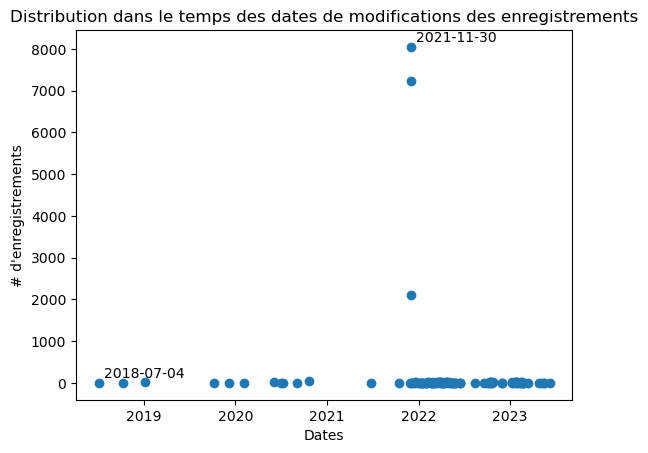

In [25]:
# lib
from datetime import datetime
#dtpoint = datetime("%d-%m-%Y")

# Afficher la distribution du nombre de documents
fig,ax = plt.subplots()

#df_trhaa_grouped.scatterplot( df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
ax.scatter(df_trhaa_groupedbydate["dtModifieLe"], df_trhaa_groupedbydate["nb_documents"])
dtpoint1 = datetime.strptime("2018-07-04", "%Y-%m-%d")
dtpoint8046 = datetime.strptime("2021-11-30", "%Y-%m-%d")
ax.annotate("2018-07-04", xy=(dtpoint1,1), xytext = (5,5), textcoords = "offset pixels")
ax.annotate("2021-11-30", xy=(dtpoint8046,8046), xytext = (5,5), textcoords = "offset pixels")
plt.title("Distribution dans le temps des dates de modifications des enregistrements")
plt.xlabel("Dates")
plt.ylabel("# d'enregistrements")
plt.show()

Text(0, 0.5, "# d'enregistrements")

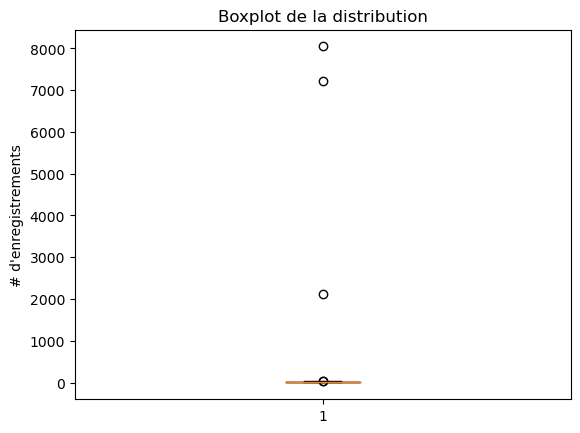

In [26]:
# Afficher

plt.boxplot(df_trhaa_groupedbydate["nb_documents"])
plt.title("Boxplot de la distribution")
plt.ylabel("# d'enregistrements")

Quel champ utiliser pour les dates de soutenance ? Existe t-il des différences entre les champs date de début de soutenance et date de fin de soutenance ? La réponse est non à 86% (16051/18220), on utilisera par la suite la date de fin de soutenance.

In [27]:
# init
df_comp_dates = pd.DataFrame([])

# Comparaison des champs
df_comp_dates["Resultat_Comp"] = (df_trhaa["SoutenanceDateDebut"]==df_trhaa["SoutenanceDateDebut"])
#print(df_comp_dates.reset_index())
print("Info: ",df_comp_dates.info())
print("index: ",df_comp_dates.index)
print("Cols: ",df_comp_dates.columns)
#print("colonnes: ",df_comp_dates.info(), "\n")
print("Nb de valeurs identiques: ", df_comp_dates["Resultat_Comp"].sum())
print("Nb de valeurs totales: ", df_comp_dates["Resultat_Comp"].count())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Resultat_Comp  18220 non-null  bool 
dtypes: bool(1)
memory usage: 17.9 KB
Info:  None
index:  RangeIndex(start=0, stop=18220, step=1)
Cols:  Index(['Resultat_Comp'], dtype='object')
Nb de valeurs identiques:  18220
Nb de valeurs totales:  18220


Etant donné que nous n'avons pas la date d'insertion des enregistrements dans la base mais seulement la date de dernière modification, nous faisons l'approximation que la date de fin de soutenance correspond à la date d'insertion à un an près.
En outre les dates de début et de fin de soutenance sont proches ?
Dans la suite de cette étude nous utiliserons la date de fin de soutenance uniquement.

Combien les étudiants ont réalisés de mémoires ou de thèses, toutes filières confondues, toutes université confondues ?

In [28]:
# init
df_trhaa["NbDocParEtudiant"] = 0

# afficher la distribution des # de documents (mémoires & thèses) par étudiant si >=2
df_trhaa_groupbyNbdoc = df_trhaa[["AuteurPrincipal","Illustration"]].groupby(["AuteurPrincipal"]).count().sort_values("Illustration",ascending=False).reset_index()
df_trhaa_groupbyNbdoc.rename(columns={'Illustration':'NbDeDocs'},inplace=True)
print(df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]>=2])
print("Nb de doc = 1, ", df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]==1]["NbDeDocs"].count())


        AuteurPrincipal  NbDeDocs
0     Méneux, Catherine         5
1        Haguet, Lucile         4
2     Fenech, Antonella         4
3      Lhermite, Xavier         4
4     Theuninck, Ingrid         4
...                 ...       ...
2741  Tavernari, Cinzia         2
2742      Bodet, Cédric         2
2743   Bonnetot, Céline         2
2744    Bolle, Gauthier         2
2745      Tequi, Pierre         2

[2746 rows x 2 columns]
Nb de doc = 1,  12289


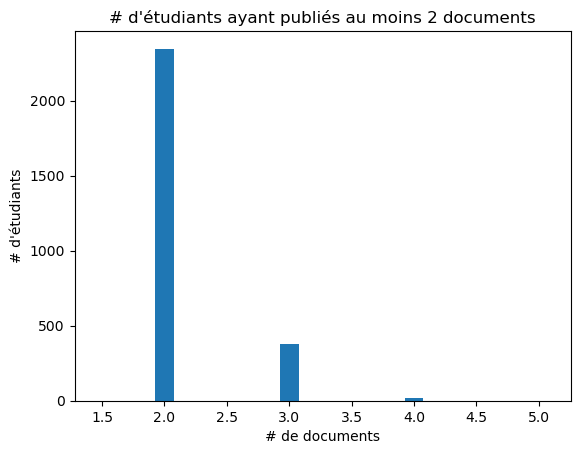

In [29]:
# Afficher la distribution du nombre de documents
fig,ax = plt.subplots()
bins=(1.5,2,3,4,5,6)
#df_trhaa_grouped.scatterplot( df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
#print(df3.describe())
ax.hist(df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]>=2]["NbDeDocs"],bins=bins, align="left",rwidth=0.15)
plt.title("# d'étudiants ayant publiés au moins 2 documents")
plt.xlabel("# de documents")
plt.ylabel("# d'étudiants")
plt.show()

Y a t-il plus de production à Paris ou en Province ?

In [30]:
# ajout d'une colonne Paris / Province
df_trhaa["UniversiteRegion"] = "Province"

#
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Panthéon-Sorbonne - Paris I", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Sorbonne - Paris IV", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole du Louvre", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Nanterre", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole pratique des hautes études", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole des hautes études en sciences sociales", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Sorbonne Université", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Versailles-Saint-Quentin-en-Yvelines", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Diderot - Paris VII", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Vincennes-Saint-Denis - Paris VIII", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Sorbonne-Nouvelle - Paris III", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Institut d'études politiques de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole pratique des hautes études - PSL", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole normale supérieure", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Cergy-Pontoise", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Institut Catholique de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Belleville", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Malaquais", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Est", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Val de Seine", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Versailles", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-La Villette", "UniversiteRegion"] = "Paris"

df_trhaa_groupedby_UniversiteRegion = df_trhaa.groupby("UniversiteRegion").count().reset_index()
df_trhaa_groupedby_UniversiteRegion.rename(columns={"Illustration":"NbUnivRegion"}, inplace=True)
print(df_trhaa_groupedby_UniversiteRegion[["UniversiteRegion","NbUnivRegion"]])

  UniversiteRegion  NbUnivRegion
0              Idf            80
1            Paris         10411
2         Province          7711


In [31]:
#
print(df_trhaa.groupby("GestionNotice")["GestionNotice"].count())

GestionNotice
Gestion notice\n    \n        Base de données\n      Travaux de recherche en histoire de l'art et archéologie, TRHAA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     3
Gestion notice\n    \n        Source\n      \n    Institut national d'histoire de l'art (France)\n  \n        Licence\n      \n    Attribution 4.0 International (CC BY 4.0)\n  \n        Base de données\n      Travaux de recherche en histoire de l'art et archéologie, TRHAA                                               

Import du fichier des prénoms téléchargé depuis le site gouv.fr et croisement avec nos données

In [32]:
# import du fichier prénom nat2021
df_datagouv_PG = pd.read_excel("input/TRHAA/nat2021.xlsx", sheet_name=0)
df_datagouv_PG.rename(columns={"preusuel":"PrenomAuteur","sexe":"Genre"},inplace=True)
df_datagouv_PG.replace({1:"Homme",2:"Femme"},inplace=True)
print(df_datagouv_PG.columns)
print(df_datagouv_PG.index)

Index(['Genre', 'PrenomAuteur', 'annais', 'nombre'], dtype='object')
RangeIndex(start=0, stop=686538, step=1)


In [33]:
df_datagouv_PG.reset_index
print(df_datagouv_PG)

        Genre    PrenomAuteur annais nombre
0       Homme  _PRENOMS_RARES   1900   1249
1       Homme  _PRENOMS_RARES   1901   1342
2       Homme  _PRENOMS_RARES   1902   1330
3       Homme  _PRENOMS_RARES   1903   1286
4       Homme  _PRENOMS_RARES   1904   1430
...       ...             ...    ...    ...
686533  Femme           ZYNEB   2018      5
686534  Femme           ZYNEB   2019      7
686535  Femme           ZYNEB   2020      8
686536  Femme           ZYNEB   2021      6
686537  Femme           ZYNEB   XXXX     19

[686538 rows x 4 columns]


In [34]:
# init. P Prenom, G Genre
#df_trhaa_P = pd.DataFrame([])

# découpage du prénom et du nom du fichier trhaa. 
df_trhaa["PrenomAuteur"] = df_trhaa_initial.AuteurPrincipal.str.split(",", expand=True)[1]
df_trhaa["PrenomAuteur"] = df_trhaa["PrenomAuteur"].str.strip()
df_trhaa["PrenomAuteur"] = df_trhaa["PrenomAuteur"].str.upper()

# groupby du fichier des prénoms sur Prenomauteur et Sexe
df_grouped_datagouv_PG = df_datagouv_PG.groupby(["PrenomAuteur","Genre"],as_index=False).size()

print(df_trhaa.shape)
print(df_grouped_datagouv_PG.shape)

# merge
df_trhaa_PG = pd.merge(df_trhaa, df_grouped_datagouv_PG, on="PrenomAuteur", how="left")

# affichage
print("info: ",df_trhaa_PG.shape)
print("info: ",df_trhaa_PG.columns)
#print("D: ",Left_Join[["PrenomAuteur","Genre"]])


(18220, 32)
(38478, 3)
info:  (25207, 34)
info:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'dtModifieLe', 'TheseInscrite', 'TheseSoutenue', 'TypeMemoireThese',
       'refPage', 'nb_documents', 'NbDocParEtudiant', 'UniversiteRegion', 'PrenomAuteur', 'Genre',
       'size'],
      dtype='object')


In [35]:
# filtre sur les années 1950 à 2023
df_trhaa_PG_2000_2023 = df_trhaa_PG[(df_trhaa_PG["SoutenanceDateFin"]>=1950) & (df_trhaa_PG["SoutenanceDateFin"]<=2024)]
df_trhaa_PG_2000_2023 = df_trhaa_PG_2000_2023.sort_values("SoutenanceDateFin",ascending=True)

# regrouper les données par Année et TypeDocument, et compter les résultats
df_trhaa_PG_grouped = df_trhaa_PG_2000_2023.groupby(["SoutenanceDateFin","TypeDocument"],as_index=False).count()

# affichage du dataframe, qques colonnes pour vérifier le format
df_trhaa_PG_grouped.rename(columns={"Illustration":"nb_docs"},inplace=True)
df_trhaa_PG_groupedforpivot = df_trhaa_PG_grouped[["SoutenanceDateFin","TypeDocument","nb_docs"]]
# affichage des colonnes pour le graphique
#print(df_trhaa_PG_grouped[["SoutenanceDateFin","TypeDocument","nb_docs"]])
print(df_trhaa_PG_groupedforpivot)
df_trhaa_PG_groupedforpivot = df_trhaa_PG_groupedforpivot[ df_trhaa_PG_groupedforpivot["TypeDocument"].isin(["thèse","mémoire"])]
print(df_trhaa_PG_groupedforpivot)

     SoutenanceDateFin TypeDocument  nb_docs
0                 1953        thèse        2
1                 1961        thèse        1
2                 1962      mémoire        1
3                 1963        thèse        2
4                 1964        thèse        2
..                 ...          ...      ...
107               2021      mémoire      203
108               2021        thèse        2
109               2022      mémoire      182
110               2022        thèse        5
111               2023      mémoire        9

[112 rows x 3 columns]
     SoutenanceDateFin TypeDocument  nb_docs
0                 1953        thèse        2
1                 1961        thèse        1
2                 1962      mémoire        1
3                 1963        thèse        2
4                 1964        thèse        2
..                 ...          ...      ...
107               2021      mémoire      203
108               2021        thèse        2
109               2022      mém

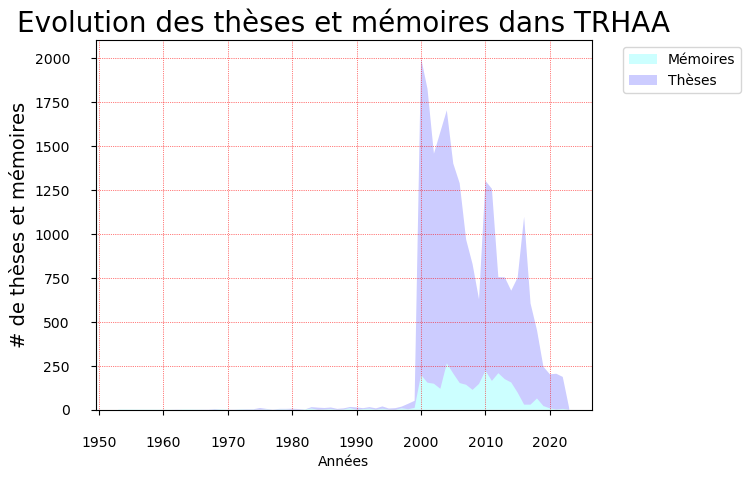

In [36]:
# affichage de l'evolution des # de mémoires et thèses dans le temps
df_trhaa_PG_pivot = pd.DataFrame([])

# pivot
df_trhaa_PG_pivot = pd.pivot_table(df_trhaa_PG_groupedforpivot,index="TypeDocument",values="nb_docs",columns="SoutenanceDateFin")
df_trhaa_PG_pivot = df_trhaa_PG_pivot.fillna(0)
df_trhaa_PG_pivot =df_trhaa_PG_pivot.T.reset_index()

# fabrication des listes pour stackplot
category = df_trhaa_PG_pivot["SoutenanceDateFin"].tolist()
values = df_trhaa_PG_pivot[[   "thèse","mémoire"
                ]].values.T.tolist()
labels = ["Mémoires","Thèses"]
colors = ["cyan","blue"]

# affichage du stackplot
plt.stackplot(category,*values,labels=labels,colors=colors, alpha=0.2)
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.title("Evolution des thèses et mémoires dans TRHAA",size=20)
plt.xlabel("Années")
plt.ylabel("# de thèses et mémoires",size=14)
plt.tick_params(axis='x', pad=15)
plt.tick_params(axis='y', pad=15)
plt.grid(True)
plt.grid(color='red', linestyle=':', linewidth=0.5,alpha=1)
plt.show()

In [37]:
# filtre sur les années 1995 à 2023
df_trhaa_PG_1995_2023 = df_trhaa_PG[(df_trhaa_PG["SoutenanceDateFin"]>=1995) & (df_trhaa_PG["SoutenanceDateFin"]<=2024)]
df_trhaa_PG_1995_2023 = df_trhaa_PG_1995_2023.sort_values("SoutenanceDateFin",ascending=True)

# regrouper les données par Année et TypeMémoire, et compter les résultats
df_trhaa_PG_grouped = df_trhaa_PG_1995_2023.groupby(["SoutenanceDateFin","TypeMemoireThese"],as_index=False).count()
df_trhaa_PG_grouped["nb_cursus"] = df_trhaa_PG_grouped["Illustration"].copy()

# affichage du dataframe, qques colonnes pour vérifier le format
#df_trhaa_PG_grouped.rename(columns={"Illustration":"nb_docs"},inplace=True)
df_trhaa_PG_groupedforpivot = df_trhaa_PG_grouped[["SoutenanceDateFin","TypeMemoireThese","nb_cursus"]]
# affichage des colonnes pour le graphique
#print(df_trhaa_PG_grouped[["SoutenanceDateFin","TypeMemoireThese","nb_cursus"]])
#print(df_trhaa_PG_groupedforpivot)
#df_trhaa_PG_groupedforpivot = df_trhaa_PG_groupedforpivot[ df_trhaa_PG_groupedforpivot["TypeMemoireThese"].isin(["thèse","mémoire"])]
print(df_trhaa_PG_groupedforpivot)#

     SoutenanceDateFin   TypeMemoireThese  nb_cursus
0                 1995       M2 Recherche          3
1                 1996       M1 Recherche          1
2                 1996       M2 Recherche          2
3                 1997       M1 Recherche          4
4                 1997  These de doctorat          3
..                 ...                ...        ...
133               2022       M1 Recherche        112
134               2022       M2 Recherche         69
135               2022  These de doctorat          4
136               2023       M1 Recherche          2
137               2023       M2 Recherche          7

[138 rows x 3 columns]


Il y a par exemple 154 étudiants reçus en Master 2 à l'Ecole du Louvre en 2021 donc à priori 154 mémoires de M2 Recherche, (https://www.ecoledulouvre.fr/sites/default/files/pdf/ssdossier1/RAP2021_pourInternet.pdf page 14) alors que la figure suivante nous montre environ 130 mémoires de M2 toutes filières d'Histoire de l'art confondues. On peut en déduire qu'il y a peu de report dans TRHAA.

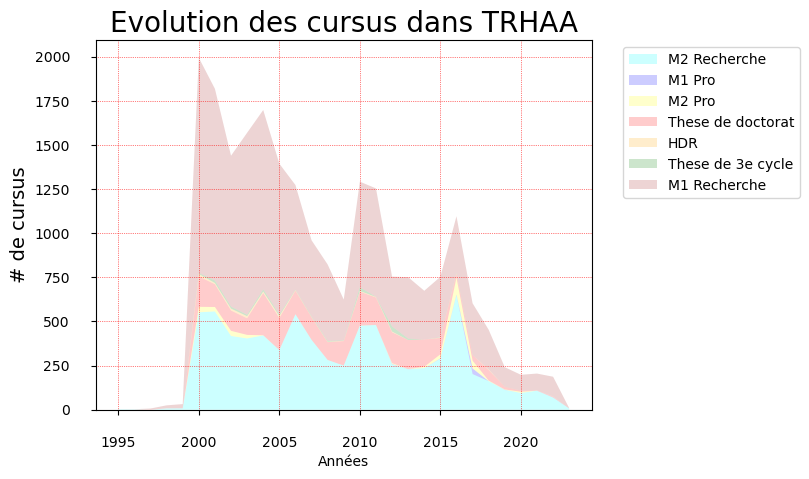

In [39]:
# Evolution des # des différents cursus dans le temps
df_trhaa_PG_pivot = pd.DataFrame([])

# pivot
df_trhaa_PG_pivot = pd.pivot_table(df_trhaa_PG_groupedforpivot,index="TypeMemoireThese",values="nb_cursus",columns="SoutenanceDateFin")
df_trhaa_PG_pivot = df_trhaa_PG_pivot.fillna(0)
df_trhaa_PG_pivot =df_trhaa_PG_pivot.T.reset_index()

# fabrication des listes pour stackplot
category = df_trhaa_PG_pivot["SoutenanceDateFin"].tolist()
values = df_trhaa_PG_pivot[[    "M2 Recherche",
                                "M1 Pro",
                                "M2 Pro",
                                "These de doctorat",
                                "HDR",
                                "These de 3e cycle",
                                "M1 Recherche",
                ]].values.T.tolist()
labels = [  "M2 Recherche",
            "M1 Pro",
            "M2 Pro",
            "These de doctorat",
            "HDR",
            "These de 3e cycle",
            "M1 Recherche"
            ]
colors = ["cyan","blue", "yellow", "red","orange","green","brown"]

# affichage du stackplot
plt.stackplot(category,*values,labels=labels,colors=colors, alpha=0.2)
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.title("Evolution des cursus dans TRHAA",size=20)
plt.xlabel("Années")
plt.ylabel("# de cursus",size=14)
plt.tick_params(axis='x', pad=15)
plt.tick_params(axis='y', pad=15)
plt.grid(True)
plt.grid(color='red', linestyle=':', linewidth=0.5,alpha=1)
plt.show()


In [ ]:
df_trhaa_11 = df_trhaa[df_trhaa["UniversitesDeSoutenancePrincipale"]=="Ecole du Louvre"]
#df_trhaa_11_2021 = df_trhaa_11[df_trhaa_11["SoutenanceDateFin"]==2021]
df_trhaa_11_these = df_trhaa_11[df_trhaa_11["TypeMemoireThese"]=="These de doctorat"]

print(df_trhaa[["SoutenanceDateFin","TypeMemoireThese","Illustration"]])

df_trhaa_22 = df_trhaa[df_trhaa["UniversitesDeSoutenancePrincipale"]=="Université Panthéon-Sorbonne - Paris I"]
#df_trhaa_22_2021 = df_trhaa_EDL[df_trhaa_EDL["SoutenanceDateFin"]==2021]
df_trhaa_22_2021_these = df_trhaa_22_2021[df_trhaa_22_2021["TypeMemoireThese"]=="These de doctorat"]

print(df_trhaa_22_2021_these[["Illustration","TypeMemoireThese"]].count())

       SoutenanceDateFin   TypeMemoireThese        Illustration
0                      0  These de doctorat  Pas d'illustration
1                   2002       M1 Recherche  Pas d'illustration
2                   2005       M2 Recherche  Pas d'illustration
3                   2002       M2 Recherche  Pas d'illustration
4                      0  These de doctorat  Pas d'illustration
...                  ...                ...                 ...
18215               2003                NaN  Pas d'illustration
18216               1934                NaN  Pas d'illustration
18217                  0                NaN  Pas d'illustration
18218                  0                NaN  Pas d'illustration
18219               1986                NaN  Pas d'illustration

[18220 rows x 3 columns]
Illustration        0
TypeMemoireThese    0
dtype: int64
